In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
class LogisticRegressionDetector:
    def __init__(self, true_data_path, fake_data_path, max_features=10000, test_size=0.3, random_state=42):
        self.true_data_path = true_data_path
        self.fake_data_path = fake_data_path
        self.max_features = max_features
        self.test_size = test_size
        self.random_state = random_state
        self.tfidf_vectorizer = TfidfVectorizer(max_features=self.max_features, stop_words='english')
        self.model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=self.random_state)

    def load_data(self):
        # Load the cleaned datasets
        true_data = pd.read_csv(self.true_data_path)
        fake_data = pd.read_csv(self.fake_data_path)

        # Add a label column to distinguish between true and fake news
        true_data['Label'] = 1
        fake_data['Label'] = 0

        # Combine the datasets
        data = pd.concat([true_data, fake_data], ignore_index=True)

        # Shuffle the data
        data = data.sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        # Drop rows with missing values
        data = data[['Content', 'Label']].dropna()

        return true_data, fake_data, data

    def preprocess_data(self, data):
        # Split the data into training and testing sets
        X = data['Content']
        y = data['Label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)

        # TF-IDF vectorization
        X_train_tfidf = self.tfidf_vectorizer.fit_transform(X_train)
        X_test_tfidf = self.tfidf_vectorizer.transform(X_test)

        return X_train_tfidf, X_test_tfidf, y_train, y_test

    def train_model(self, X_train_tfidf, y_train):
        self.model.fit(X_train_tfidf, y_train)

    def evaluate_model(self, X_test_tfidf, y_test):
        y_pred = self.model.predict(X_test_tfidf)
        y_pred_proba = self.model.predict_proba(X_test_tfidf)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        classification_rep = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print("Accuracy:", accuracy)
        print("ROC AUC Score:", roc_auc)
        print("\nClassification Report:\n", classification_rep)
        print("\nConfusion Matrix:\n", conf_matrix)

        return accuracy, roc_auc, classification_rep, conf_matrix

    def visualize_pca(self, X_train_tfidf, X_test_tfidf, y_train, y_test):
        pca = PCA(n_components=2, random_state=self.random_state)
        X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
        X_test_pca = pca.transform(X_test_tfidf.toarray())

        X_pca = pd.DataFrame(
            data=np.vstack((X_train_pca, X_test_pca)),
            columns=['PC1', 'PC2']
        )
        y_combined = pd.concat([y_train.reset_index(drop=True), y_test.reset_index(drop=True)], ignore_index=True)

        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(
            X_pca['PC1'], X_pca['PC2'],
            c=y_combined, cmap='coolwarm', alpha=0.6, edgecolors='k'
        )
        plt.colorbar(scatter, label='Label')
        plt.title('Scatter Plot of Word Embeddings (PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()

    def visualize_feature_importance(self):
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        coefficients = self.model.coef_.flatten()

        sorted_indices = np.argsort(np.abs(coefficients))[::-1]
        top_features = feature_names[sorted_indices][:20]  # Top 20 features
        top_coefficients = coefficients[sorted_indices][:20]

        plt.figure(figsize=(12, 6))
        markerline, stemlines, baseline = plt.stem(
            range(len(top_coefficients)), top_coefficients, linefmt='b-', markerfmt='bo', basefmt="k-"
        )
        plt.xticks(range(len(top_features)), top_features, rotation=90)
        plt.title('Top 20 Feature Coefficients in Logistic Regression')
        plt.ylabel('Coefficient Value')
        plt.xlabel('Features')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

Accuracy: 0.9862758260610129
ROC AUC Score: 0.9985687949828486

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      7044
           1       0.98      0.99      0.99      6363

    accuracy                           0.99     13407
   macro avg       0.99      0.99      0.99     13407
weighted avg       0.99      0.99      0.99     13407


Confusion Matrix:
 [[6933  111]
 [  73 6290]]


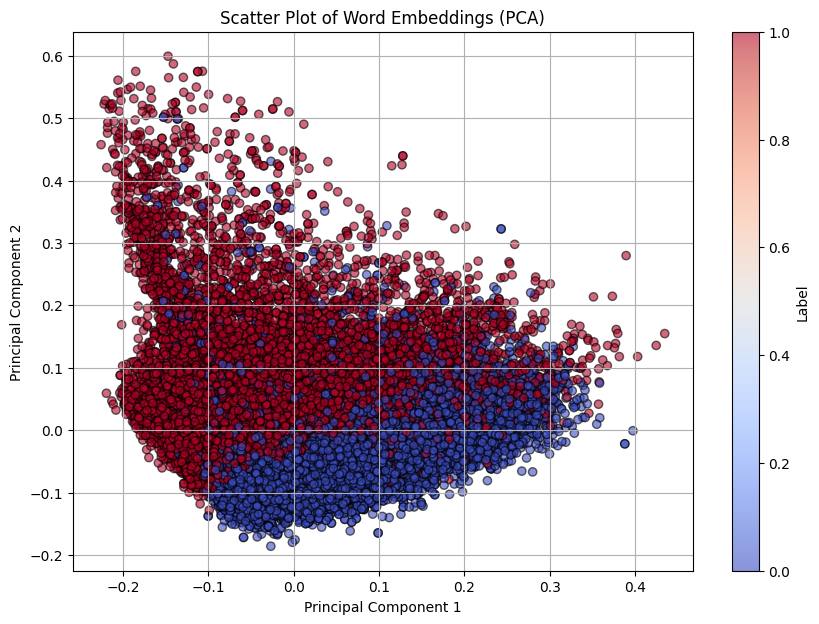

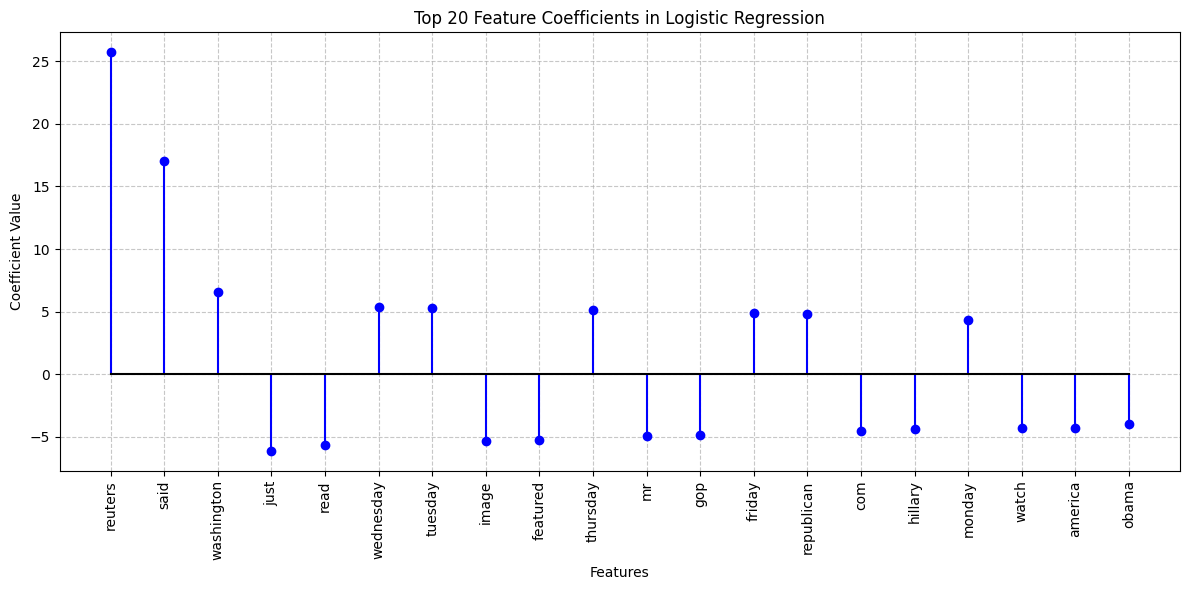

In [3]:
# Create an instance of the LogisticRegressionDetector class
detector = LogisticRegressionDetector(true_data_path='Cleaned_True_Data.csv', fake_data_path='Cleaned_False_Data.csv')

# Load and preprocess the data
true_data, fake_data, data = detector.load_data()
X_train_tfidf, X_test_tfidf, y_train, y_test = detector.preprocess_data(data)

# Train the model
detector.train_model(X_train_tfidf, y_train)

# Evaluate the model
accuracy, roc_auc, classification_rep, conf_matrix = detector.evaluate_model(X_test_tfidf, y_test)

# Visualize PCA
detector.visualize_pca(X_train_tfidf, X_test_tfidf, y_train, y_test)

# Visualize feature importance
detector.visualize_feature_importance()
